In [20]:
# 1) 데이터 로드 및 전처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 차트 데이터 로드
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.rename(columns={
    'date': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

# 온체인 데이터 로드 및 Value (USD) 전처리
df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
df_chain['ValueUSD'] = (
    df_chain['Value (USD)']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)
df_chain['Date'] = pd.to_datetime(df_chain['Date'])
df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)

# 병합 후 정렬 및 인덱스 설정
df_merged = pd.merge(
    df_chart,
    df_chain[['Date', 'OnchainValue']],
    on='Date',
    how='inner'
)
df_merged.sort_values('Date', inplace=True)
df_merged.set_index('Date', inplace=True)


In [17]:
# 2) 월별/주간 집계
# 월별 집계
monthly = df_merged.resample('M').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
})
monthly.reset_index(inplace=True)

# 주간 집계 (월요일 기준)
weekly = df_merged.resample('W-MON').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
})
weekly.reset_index(inplace=True)


C:\Users\kmj\AppData\Local\Temp\ipykernel_12600\476973784.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_merged.resample('M').agg({


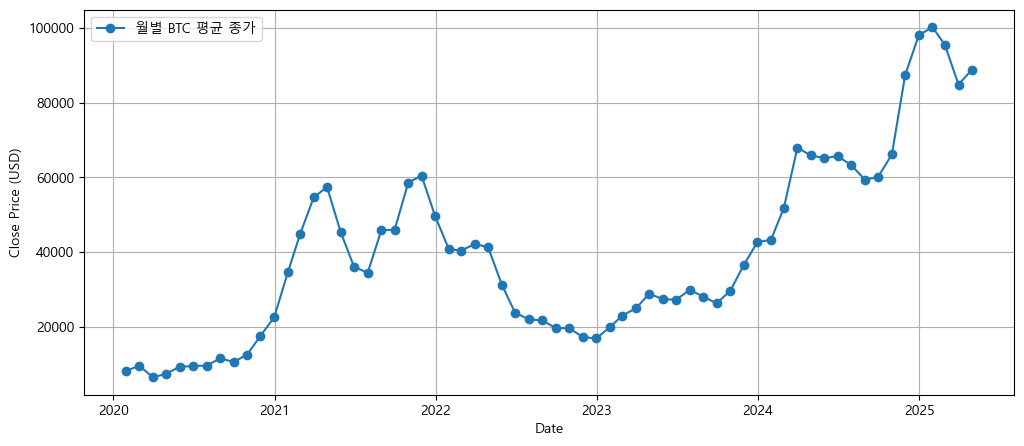

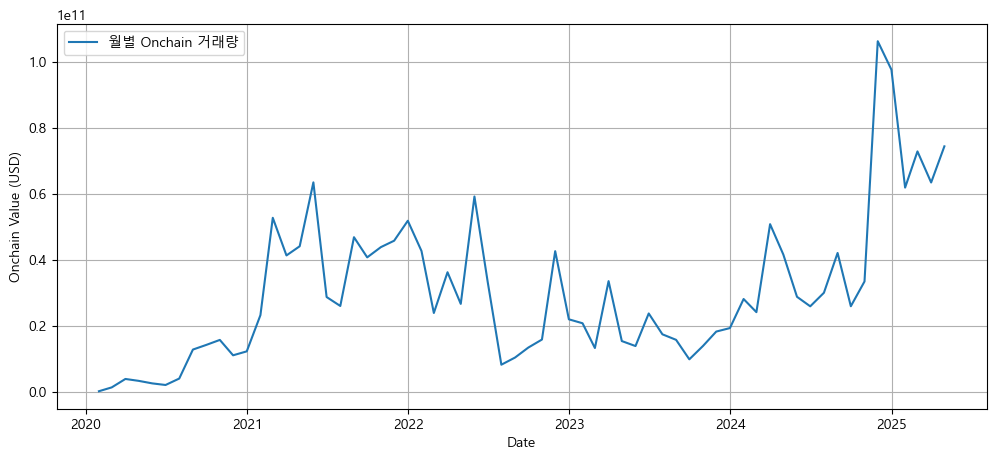

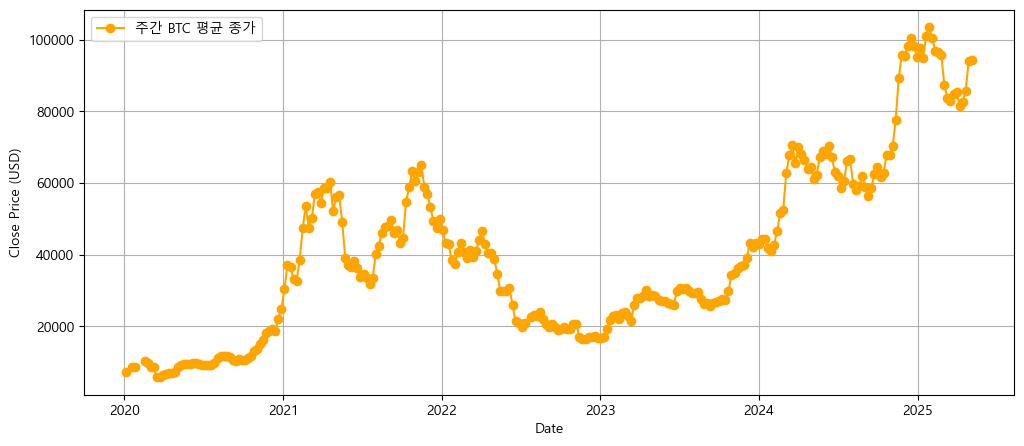

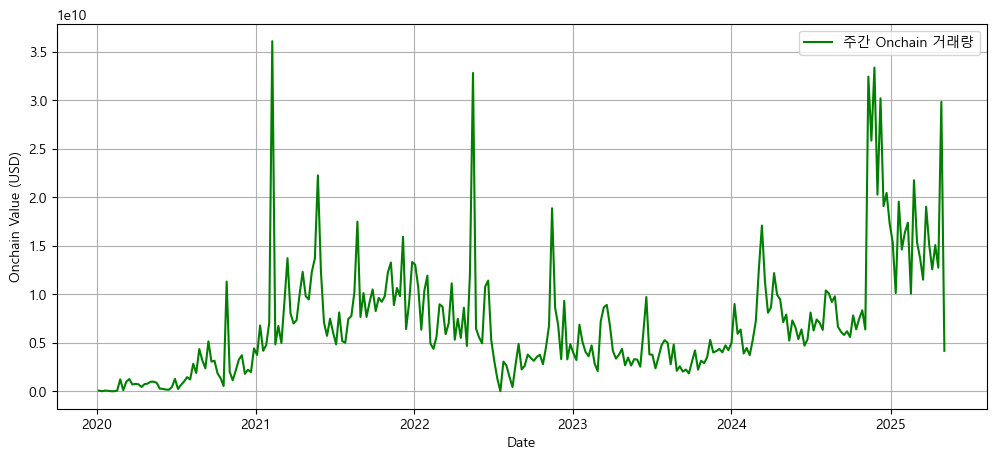

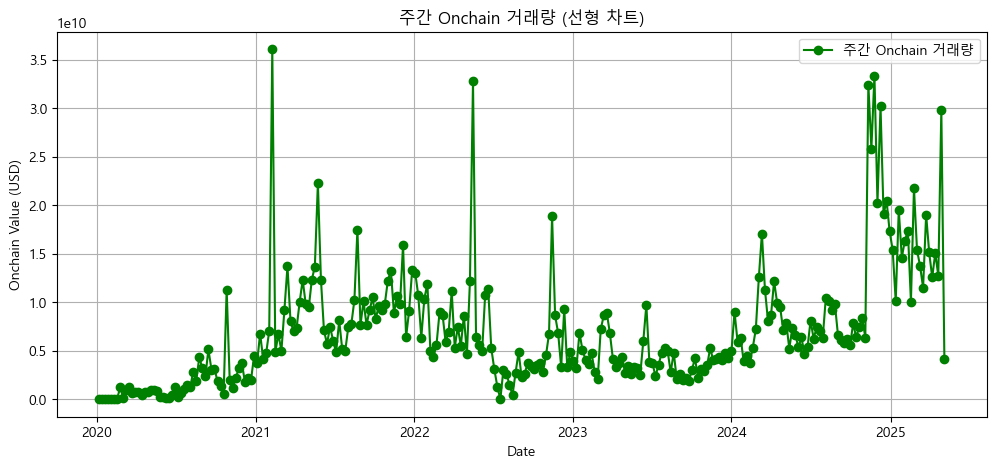

In [21]:
# 3) 시각화 (월별/주간 BTC 평균 종가 및 Onchain 거래량)
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 월별 BTC 평균 종가
plt.figure(figsize=(12, 5))
plt.plot(monthly['Date'], monthly['Close'], marker='o', label='월별 BTC 평균 종가')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 월별 Onchain 거래량
plt.figure(figsize=(12, 5))
plt.plot(monthly['Date'], monthly['OnchainValue'], linestyle='-', label='월별 Onchain 거래량')
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 주간 BTC 평균 종가
plt.figure(figsize=(12, 5))
plt.plot(weekly['Date'], weekly['Close'], marker='o', color='orange', label='주간 BTC 평균 종가')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 주간 Onchain 거래량
plt.figure(figsize=(12, 5))
plt.plot(weekly['Date'], weekly['OnchainValue'], color='green', label='주간 Onchain 거래량')
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 주간 Onchain 거래량을 선형(라인) 차트로 그리기
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 5))
plt.plot(weekly['Date'], weekly['OnchainValue'], linestyle='-', marker='o', color='green', label='주간 Onchain 거래량')
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.title('주간 Onchain 거래량 (선형 차트)')
plt.grid(True)
plt.legend()
plt.show()



C:\Users\kmj\AppData\Local\Temp\ipykernel_12600\70766459.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


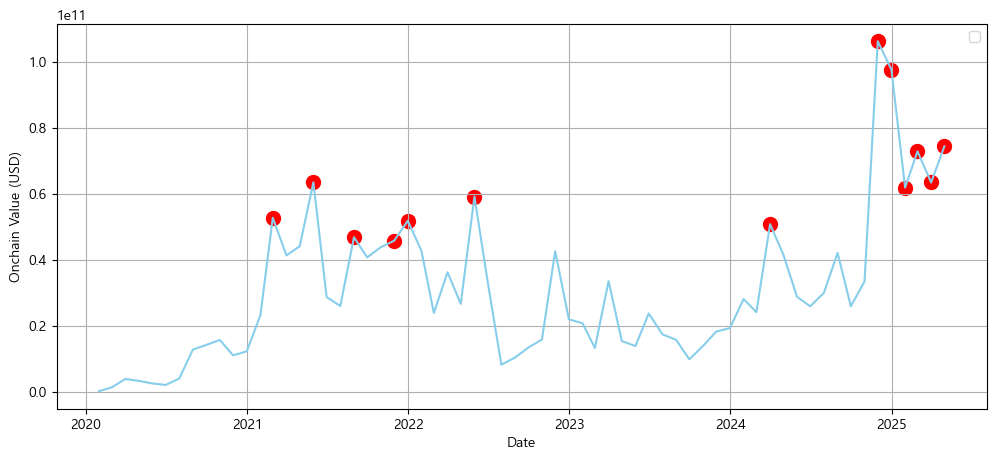

C:\Users\kmj\AppData\Local\Temp\ipykernel_12600\70766459.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


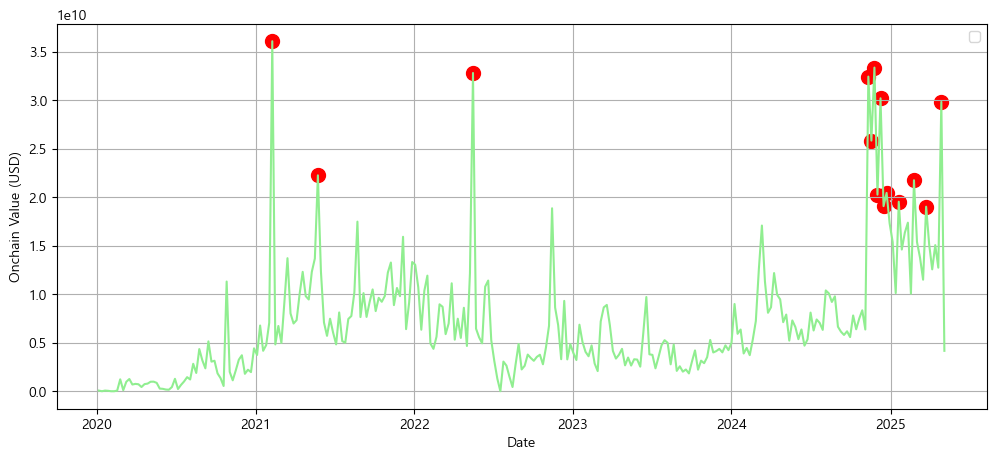

In [28]:
# 4) 스파이크 탐지 (상위 n% 기준)
import numpy as np

# 월별 스파이크
n = 20
onchain_spike_threshold_month = np.percentile(monthly['OnchainValue'], 100-n)
monthly['Spike'] = monthly['OnchainValue'] > onchain_spike_threshold_month

plt.figure(figsize=(12, 5))
plt.plot(monthly['Date'], monthly['OnchainValue'], color='skyblue')
plt.scatter(
    monthly[monthly['Spike']]['Date'],
    monthly[monthly['Spike']]['OnchainValue'],
    color='red', s=100
)
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 주간 스파이크
onchain_spike_threshold_week = np.percentile(weekly['OnchainValue'], 95)
weekly['Spike'] = weekly['OnchainValue'] > onchain_spike_threshold_week

plt.figure(figsize=(12, 5))
plt.plot(weekly['Date'], weekly['OnchainValue'], color='lightgreen')
plt.scatter(
    weekly[weekly['Spike']]['Date'],
    weekly[weekly['Spike']]['OnchainValue'],
    color='red', s=100
)
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.grid(True)
plt.legend()
plt.show()


c:\Users\kmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0026 - val_loss: 7.8292e-05
Epoch 2/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.1007e-05 - val_loss: 7.5210e-05
Epoch 3/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.4714e-05 - val_loss: 1.1845e-04
Epoch 4/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4.3816e-05 - val_loss: 3.2910e-05
Epoch 5/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.3712e-05 - val_loss: 1.0892e-04
Epoch 6/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.3594e-05 - val_loss: 6.9441e-05
Epoch 7/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.5769e-05 - val_loss: 1.6122e-05
Epoch 8/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.2204e-05 - val_loss: 1.8875e-05
Epoch 9/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.2011e-05 - val_loss: 4.3295e-05
Epoch 10/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.5044e-05 - val_loss: 1.7506e-05
Epoch 11/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.

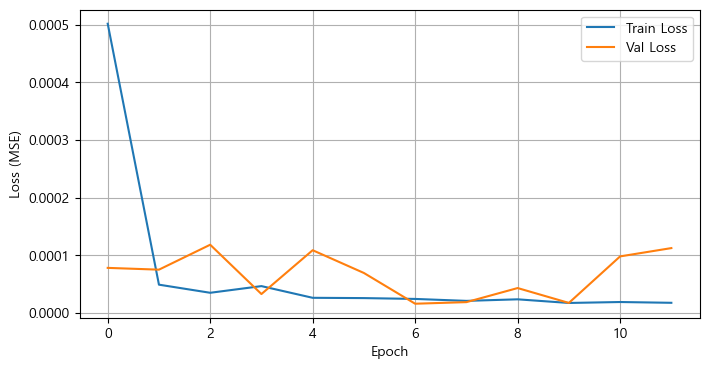

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


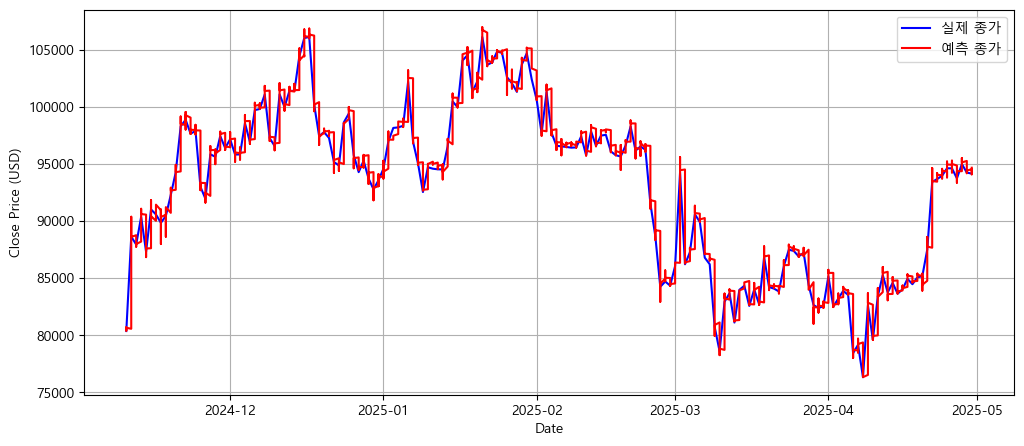

In [29]:
# 5) CNN 예측 모델 준비 및 학습
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# 특성 및 정규화
data = df_merged[['Close', 'OnchainValue']].copy()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 시퀀스 생성 함수
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # Close 가격 예측
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled_data, window_size)

# 훈련/테스트 분리 (80% train)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# CNN 모델 정의
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 2)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 학습 손실 시각화
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.show()

# 예측 및 역변환
y_pred = model.predict(X_test)
y_test_rescaled = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 1))))
)[:, 0]
y_pred_rescaled = scaler.inverse_transform(
    np.hstack((y_pred, np.zeros((len(y_pred), 1))))
)[:, 0]

# 실제 vs 예측 시각화
plt.figure(figsize=(12, 5))
plt.plot(df_merged.index[-len(y_test):], y_test_rescaled, label='실제 종가', color='blue')
plt.plot(df_merged.index[-len(y_pred):], y_pred_rescaled, label='예측 종가', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()
plt.show()


이 코드에서는 ‘Close’와 ‘OnchainValue’ 두 가지 특성을 이용해, 과거 30일치 데이터를 입력으로 받아 다음날 종가를 예측하는 1D CNN 모델을 만들고 학습합니다. 주요 단계는 다음과 같습니다:

데이터 정규화: MinMaxScaler로 두 특성 값을 0~1 범위로 스케일링.

시퀀스 생성: 과거 30일치(window_size=30) 데이터를 묶어 입력(X)으로 만들고, 그 다음날 종가(y)를 레이블로 생성.

훈련/테스트 분리: 전체 시퀀스의 80%를 훈련용, 나머지를 테스트용으로 분리.

CNN 모델 구성:

첫 번째 Conv1D(32, kernel_size=3, relu)

두 번째 Conv1D(64, kernel_size=3, relu)

Flatten → Dense(50, relu) → Dense(1)
이 구조로 과거 데이터 시퀀스에서 특징을 뽑아 종가를 예측하도록 설계.

모델 학습:

옵티마이저는 Adam, 손실 함수는 MSE.

검증 손실(val_loss)을 기준으로 5회 연속 개선이 없으면 조기 종료(EarlyStopping).

학습 도중 훈련/검증 손실을 그래프로 시각화하여 과적합 여부 확인.

예측 및 역변환:

테스트 세트에 대해 예측한 값(y_pred)을, 스케일링 이전의 원래 가격 단위로 되돌린 뒤(inverse_transform),

실제 종가와 예측 종가를 시간 축에 따라 비교해 그래프로 표시.

요약하면, 과거 30일간의 종가와 온체인 거래량 데이터를 바탕으로 CNN을 학습시켜, 다음날 종가를 예측한 뒤 그 결과를 시각화하는 과정입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

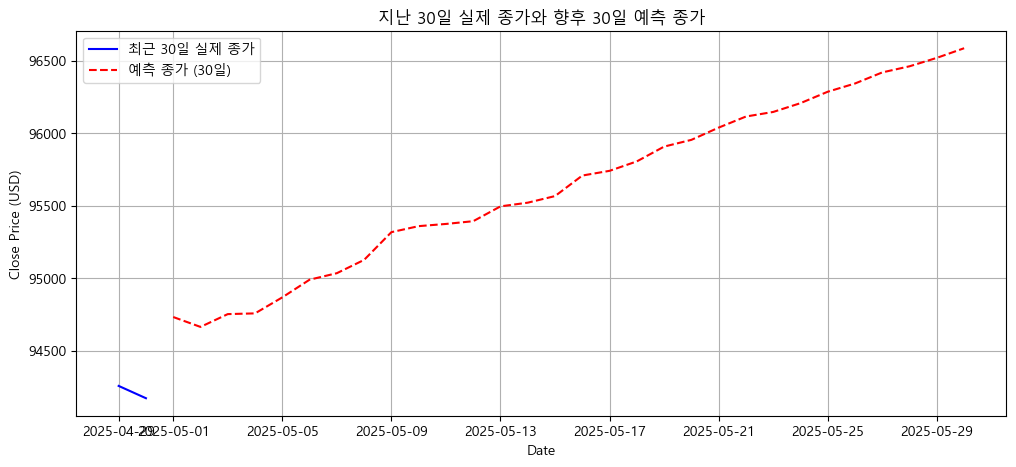

In [30]:
# ─── 6) 30일치 반복 예측(Recursive Forecasting) ───────────────────────────────────

# 1) 마지막 학습용 스케일링된 데이터(window_size일치) 가져오기
last_seq = scaled_data[-window_size:].copy()  
#    scaled_data는 앞서 MinMaxScaler 로 변환해 둔 (종가, 온체인) 배열 전체
#    마지막 window_size (=30)개 행을 잘라서, 이후 예측에 사용할 준비를 합니다.

future_days = 30  # 예측할 기간: 30일
predictions_30 = []  # 역변환된 실제 단위(USD) 예측값을 저장할 리스트

for _ in range(future_days):
    # 2) 모델 입력 형태로 reshape → (1, window_size, 2)
    x_input = last_seq.reshape((1, window_size, 2))
    # 3) 다음 1일 뒤 종가 예측 (스케일링된 값)
    y_next_scaled = model.predict(x_input)  # shape = (1, 1)

    # 4) 역변환: MinMaxScaler.inverse_transform을 쓰려면 (종가, 온체인) 쌍으로 넣어야 하므로
    #    두 번째 온체인 값은 0으로 채워서 같이 변환 → 이후 인덱스 0만 꺼냄
    y_next_rescaled = scaler.inverse_transform(
        np.hstack((y_next_scaled, np.zeros((1, 1))))
    )[0, 0]
    predictions_30.append(y_next_rescaled)

    # 5) 다음 예측에 쓸 시퀀스 업데이트
    #    - 앞에서 가장 오래된 1개 행(last_seq[0])을 버리고
    #    - 새로 예측된 “종가(스케일링된 상태)”를 두 번째 채널(온체인=0)과 함께 맨 뒤에 붙임
    new_row = np.array([y_next_scaled[0, 0], 0.0])  # (종가_scaled, 온체인=0)
    last_seq = np.vstack((last_seq[1:], new_row))   # shape 유지: (30, 2)

# 6) 예측 결과 시각화: 원본 df_merged 인덱스 뒤에 이어 붙을 날짜가 없으므로,
#    plt.date_range로 ‘마지막 날짜+1’부터 30일만큼의 날짜 시퀀스를 만들고 플롯
import pandas as pd

# df_merged.index가 datetime 형식이라고 가정
start_date = df_merged.index[-1] + pd.Timedelta(days=1)
future_index = pd.date_range(start=start_date, periods=future_days, freq='D')

plt.figure(figsize=(12, 5))
# ── (1) 학습 데이터 마지막 일부: 시각적으로 비교하기 위해, 실제 “최근 30일”을 파란색으로 그립니다
plt.plot(
    df_merged.index[-window_size:], 
    scaler.inverse_transform(
        np.hstack((scaled_data[-window_size:, :1], np.zeros((window_size, 1))))
    )[:, 0],
    label='최근 30일 실제 종가', color='blue'
)
# ── (2) 30일 예측 결과: 빨간색 점선으로
plt.plot(future_index, predictions_30, label='예측 종가 (30일)', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('지난 30일 실제 종가와 향후 30일 예측 종가')
plt.grid(True)
plt.legend()
plt.show()


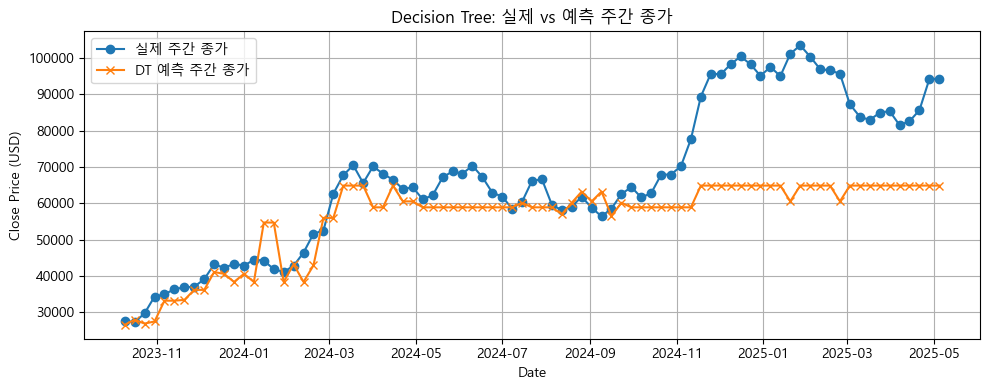

===== 회귀 모델 성능 (RMSE, R²) =====
            Model       RMSE      R2
Linear Regression  3784.3622  0.9660
    Decision Tree 16843.2949  0.3264
Gradient Boosting 17783.9409  0.2490
              SVR 45078.4685 -3.8252

===== 분류 모델 성능 (F1 Score) =====
              Model  F1 Score
Logistic Regression    0.0000
      Decision Tree    0.4578
  Gradient Boosting    0.2000
                SVC    0.6729

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0     0.3800    0.5758    0.4578        33
           1     0.5758    0.3800    0.4578        50

    accuracy                         0.4578        83
   macro avg     0.4779    0.4779    0.4578        83
weighted avg     0.4979    0.4578    0.4578        83



In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# ─── 1) 데이터 로드 및 주간 집계 ─────────────────────────────────────────
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.rename(columns={'date': 'Date', 'close': 'Close'}, inplace=True)

df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
df_chain['ValueUSD'] = (
    df_chain['Value (USD)']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)
df_chain['Date'] = pd.to_datetime(df_chain['Date'])
df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)

df_merged = pd.merge(
    df_chart[['Date', 'Close']],
    df_chain[['Date', 'OnchainValue']],
    on='Date',
    how='inner'
)
df_merged.set_index('Date', inplace=True)

weekly = df_merged.resample('W-MON').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).dropna().reset_index()

# ─── 2) 특성/레이블 생성 ──────────────────────────────────────────────────
weekly['ClosePrev'] = weekly['Close'].shift(1)
weekly['OnchainPrev'] = weekly['OnchainValue'].shift(1)
data = weekly.dropna(subset=['ClosePrev', 'OnchainPrev']).copy()

# 회귀용
X_reg = data[['OnchainPrev', 'ClosePrev']].values
y_reg = data['Close'].values

# 분류용 (Previous 대비 상승(1)/하락(0))
data['Direction'] = np.where(data['Close'] > data['ClosePrev'], 1, 0)
X_clf = data[['OnchainPrev', 'ClosePrev']].values
y_clf = data['Direction'].values

# ─── 3) 훈련/테스트 분리 ──────────────────────────────────────────────────
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.3, shuffle=False
)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.3, shuffle=False
)

# ─── 4) 회귀 모델 정의 (Random Forest 대신 Decision Tree) ───────────────
regressors = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

# ─── 5) 분류 모델 정의 (Random Forest 대신 Decision Tree) ───────────────
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVC': SVC(kernel='rbf')
}

# ─── 6) 회귀 학습 및 평가 ─────────────────────────────────────────────────
reg_results = []
for name, model in regressors.items():
    model.fit(Xr_train, yr_train)
    y_pred = model.predict(Xr_test)
    rmse = np.sqrt(mean_squared_error(yr_test, y_pred))
    r2 = r2_score(yr_test, y_pred)
    reg_results.append({'Model': name, 'RMSE': rmse, 'R2': r2})

reg_results_df = pd.DataFrame(reg_results)

# ─── 7) 분류 학습 및 F1 스코어 평가 ───────────────────────────────────────
clf_results = []
for name, model in classifiers.items():
    model.fit(Xc_train, yc_train)
    y_pred = model.predict(Xc_test)
    f1 = f1_score(yc_test, y_pred, average='binary')
    clf_results.append({'Model': name, 'F1 Score': f1})

clf_results_df = pd.DataFrame(clf_results)

# ─── 8) 결과 시각화 예시: Decision Tree Regressor ───────────────────────
dt = regressors['Decision Tree']
y_pred_dt = dt.predict(Xr_test)

plt.figure(figsize=(10, 4))
plt.plot(data['Date'].iloc[-len(yr_test):], yr_test, label='실제 주간 종가', marker='o')
plt.plot(data['Date'].iloc[-len(yr_test):], y_pred_dt, label='DT 예측 주간 종가', marker='x')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Decision Tree: 실제 vs 예측 주간 종가')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── 9) 결과 출력 ───────────────────────────────────────────────────────
print("===== 회귀 모델 성능 (RMSE, R²) =====")
print(reg_results_df.to_string(index=False, float_format='{:.4f}'.format))

print("\n===== 분류 모델 성능 (F1 Score) =====")
print(clf_results_df.to_string(index=False, float_format='{:.4f}'.format))

# ─── 10) 예시: Decision Tree 분류 리포트 ─────────────────────────────────
dt_clf = classifiers['Decision Tree']
y_pred_dt_clf = dt_clf.predict(Xc_test)
print("\nDecision Tree Classification Report:")
print(classification_report(yc_test, y_pred_dt_clf, digits=4))


모델별 비교 설명하기기